In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from preprocessing import (
    read_csv_files, filter_nodes, convert_dates_to_datetime,
    add_holidays,add_weather_data,set_indexes_for_timeseries,
    get_train_test,fill_missing_values
)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [2]:
DATA_DIR = './data'
filenames = ['champs-elysees.csv', 'convention.csv', 'saints-peres.csv']
dfs = read_csv_files(DATA_DIR, filenames)

In [3]:
TIME_WINDOW = 14

In [4]:
df = pd.concat(dfs)
df.head()

,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,Date debut dispo data,Date fin dispo data,geo_point_2d,geo_shape,filename
ds,,,,,,,,,,,,,,,
2021-11-01 04:00:00,AV_Champs_Elysees,2021-11-01 04:00:00,1222.0,42.87945,Saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.871535879911605,2.301722792456062","{""coordinates"": [[2.3009951475, 48.8717770435]...",champs-elysees.csv
2021-11-01 05:00:00,AV_Champs_Elysees,2021-11-01 05:00:00,1033.0,44.35278,Saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.871535879911605,2.301722792456062","{""coordinates"": [[2.3009951475, 48.8717770435]...",champs-elysees.csv
2021-11-01 06:00:00,AV_Champs_Elysees,2021-11-01 06:00:00,824.0,20.16222,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.871535879911605,2.301722792456062","{""coordinates"": [[2.3009951475, 48.8717770435]...",champs-elysees.csv
2021-11-01 07:00:00,AV_Champs_Elysees,2021-11-01 07:00:00,710.0,12.20000,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.871535879911605,2.301722792456062","{""coordinates"": [[2.3009951475, 48.8717770435]...",champs-elysees.csv
2021-11-01 08:00:00,AV_Champs_Elysees,2021-11-01 08:00:00,947.0,40.57222,Saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.871535879911605,2.301722792456062","{""coordinates"": [[2.3009951475, 48.8717770435]...",champs-elysees.csv


In [5]:
df.isna().sum()

Libelle                          0
Date et heure de comptage        0
Débit horaire                61243
Taux d'occupation            58399
Etat trafic                      0
Identifiant noeud amont          0
Libelle noeud amont              0
Identifiant noeud aval           0
Libelle noeud aval               0
Etat arc                         0
Date debut dispo data            0
Date fin dispo data              0
geo_point_2d                     0
geo_shape                        0
filename                         0
dtype: int64

In [6]:
df_filtered = filter_nodes(df)

In [7]:
df_filtered.shape

(27908, 15)

In [8]:
df_filtered = df_filtered.drop(['Libelle noeud amont','Libelle noeud aval'],axis=1)

In [9]:
df_filtered.shape

(27908, 13)

In [10]:
df_filtered.head()

,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Identifiant noeud aval,Etat arc,Date debut dispo data,Date fin dispo data,geo_point_2d,geo_shape,filename
ds,,,,,,,,,,,,,
2021-11-01 04:00:00,AV_Champs_Elysees,2021-11-01 04:00:00,1222.0,42.87945,Saturé,2294,2293,Invalide,2005-01-01,2019-06-01,"48.871535879911605,2.301722792456062","{""coordinates"": [[2.3009951475, 48.8717770435]...",champs-elysees.csv
2021-11-01 05:00:00,AV_Champs_Elysees,2021-11-01 05:00:00,1033.0,44.35278,Saturé,2294,2293,Invalide,2005-01-01,2019-06-01,"48.871535879911605,2.301722792456062","{""coordinates"": [[2.3009951475, 48.8717770435]...",champs-elysees.csv
2021-11-01 06:00:00,AV_Champs_Elysees,2021-11-01 06:00:00,824.0,20.16222,Pré-saturé,2294,2293,Invalide,2005-01-01,2019-06-01,"48.871535879911605,2.301722792456062","{""coordinates"": [[2.3009951475, 48.8717770435]...",champs-elysees.csv
2021-11-01 07:00:00,AV_Champs_Elysees,2021-11-01 07:00:00,710.0,12.20000,Fluide,2294,2293,Invalide,2005-01-01,2019-06-01,"48.871535879911605,2.301722792456062","{""coordinates"": [[2.3009951475, 48.8717770435]...",champs-elysees.csv
2021-11-01 08:00:00,AV_Champs_Elysees,2021-11-01 08:00:00,947.0,40.57222,Saturé,2294,2293,Invalide,2005-01-01,2019-06-01,"48.871535879911605,2.301722792456062","{""coordinates"": [[2.3009951475, 48.8717770435]...",champs-elysees.csv


<AxesSubplot: xlabel='ds'>

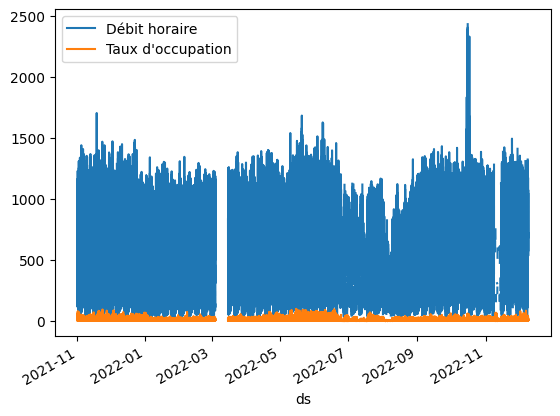

In [11]:

df_filtered[['Débit horaire', "Taux d'occupation"]].plot()

In [12]:
df_filtered.isna().sum()

Libelle                         0
Date et heure de comptage       0
Débit horaire                2013
Taux d'occupation            1279
Etat trafic                     0
Identifiant noeud amont         0
Identifiant noeud aval          0
Etat arc                        0
Date debut dispo data           0
Date fin dispo data             0
geo_point_2d                    0
geo_shape                       0
filename                        0
dtype: int64

In [13]:
df_filtered

,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Identifiant noeud aval,Etat arc,Date debut dispo data,Date fin dispo data,geo_point_2d,geo_shape,filename
ds,,,,,,,,,,,,,
2021-11-01 04:00:00,AV_Champs_Elysees,2021-11-01 04:00:00,1222.0,42.87945,Saturé,2294,2293,Invalide,2005-01-01,2019-06-01,"48.871535879911605,2.301722792456062","{""coordinates"": [[2.3009951475, 48.8717770435]...",champs-elysees.csv
2021-11-01 05:00:00,AV_Champs_Elysees,2021-11-01 05:00:00,1033.0,44.35278,Saturé,2294,2293,Invalide,2005-01-01,2019-06-01,"48.871535879911605,2.301722792456062","{""coordinates"": [[2.3009951475, 48.8717770435]...",champs-elysees.csv
2021-11-01 06:00:00,AV_Champs_Elysees,2021-11-01 06:00:00,824.0,20.16222,Pré-saturé,2294,2293,Invalide,2005-01-01,2019-06-01,"48.871535879911605,2.301722792456062","{""coordinates"": [[2.3009951475, 48.8717770435]...",champs-elysees.csv
2021-11-01 07:00:00,AV_Champs_Elysees,2021-11-01 07:00:00,710.0,12.20000,Fluide,2294,2293,Invalide,2005-01-01,2019-06-01,"48.871535879911605,2.301722792456062","{""coordinates"": [[2.3009951475, 48.8717770435]...",champs-elysees.csv
2021-11-01 08:00:00,AV_Champs_Elysees,2021-11-01 08:00:00,947.0,40.57222,Saturé,2294,2293,Invalide,2005-01-01,2019-06-01,"48.871535879911605,2.301722792456062","{""coordinates"": [[2.3009951475, 48.8717770435]...",champs-elysees.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-08 20:00:00,Sts_Peres,2022-12-08 20:00:00,806.0,10.53389,Fluide,114,119,Invalide,2005-01-01,2019-06-01,"48.85728037123275,2.332454190717672","{""coordinates"": [[2.3332577811223216, 48.85826...",saints-peres.csv
2022-12-08 21:00:00,Sts_Peres,2022-12-08 21:00:00,684.0,9.73722,Fluide,114,119,Invalide,2005-01-01,2019-06-01,"48.85728037123275,2.332454190717672","{""coordinates"": [[2.3332577811223216, 48.85826...",saints-peres.csv
2022-12-08 22:00:00,Sts_Peres,2022-12-08 22:00:00,533.0,6.78833,Fluide,114,119,Invalide,2005-01-01,2019-06-01,"48.85728037123275,2.332454190717672","{""coordinates"": [[2.3332577811223216, 48.85826...",saints-peres.csv


<AxesSubplot: >

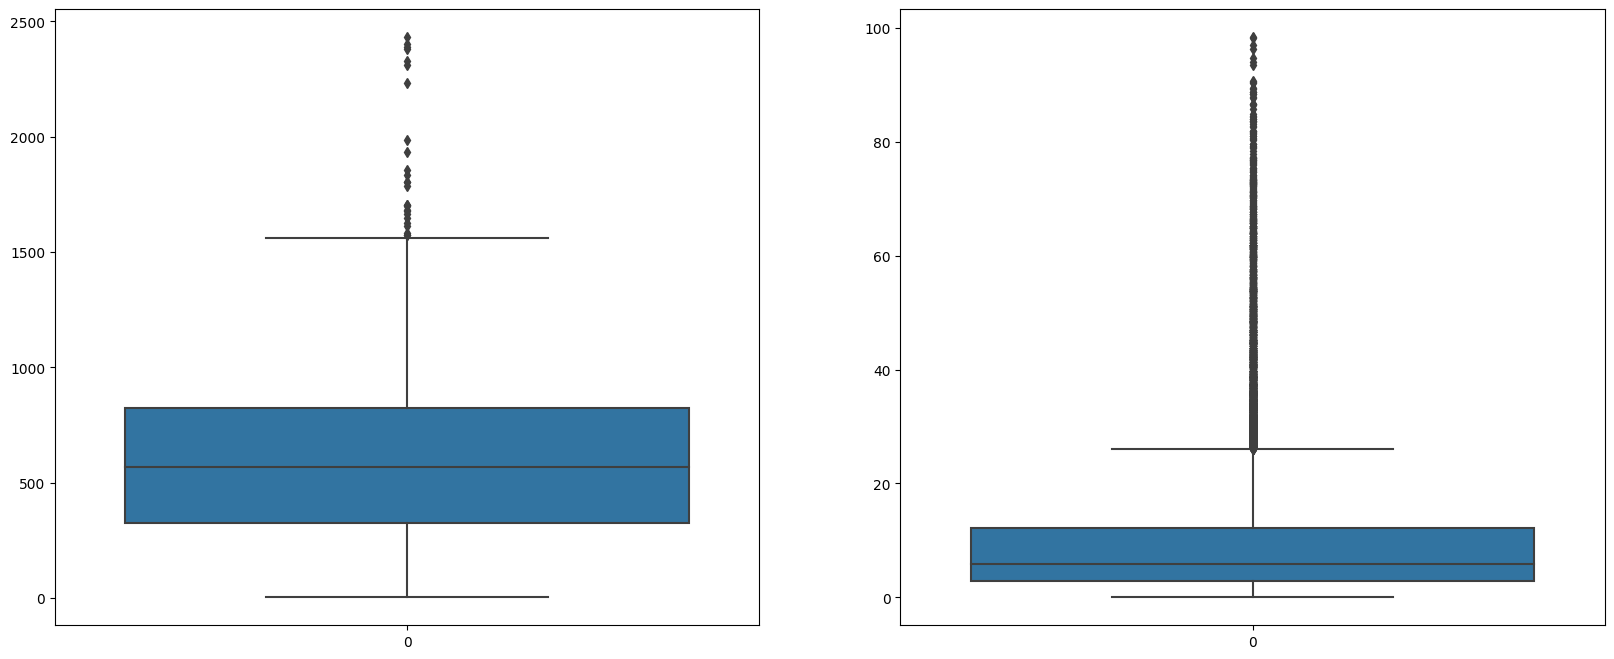

In [14]:
plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
sns.boxplot(df_filtered['Débit horaire'])

plt.subplot(1, 2, 2)
sns.boxplot(df_filtered["Taux d'occupation"])

In [15]:
df_filtered['Jour de la semaine'] = pd.to_datetime(df_filtered["Date et heure de comptage"]).dt.dayofweek
df_filtered = pd.concat([
    df_filtered,
    pd.get_dummies(df_filtered['Jour de la semaine'],prefix='Jour de la semaine')
], axis=1).drop(columns=['Jour de la semaine'])

df_filtered.sample(10)

,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Identifiant noeud aval,Etat arc,Date debut dispo data,Date fin dispo data,geo_point_2d,geo_shape,filename,Jour de la semaine_0,Jour de la semaine_1,Jour de la semaine_2,Jour de la semaine_3,Jour de la semaine_4,Jour de la semaine_5,Jour de la semaine_6
ds,,,,,,,,,,,,,,,,,,,,
2022-08-03 03:00:00,Sts_Peres,2022-08-03 03:00:00,90.0,1.09611,Fluide,114,119,Invalide,2005-01-01,2019-06-01,"48.85728037123275,2.3324541907176717","{""coordinates"": [[2.3332577811, 48.858260067],...",saints-peres.csv,0,0,1,0,0,0,0
2021-12-26 16:00:00,Sts_Peres,2021-12-26 16:00:00,356.0,4.82556,Fluide,114,119,Invalide,2005-01-01,2019-06-01,"48.85728037123275,2.3324541907176717","{""coordinates"": [[2.3332577811, 48.858260067],...",saints-peres.csv,0,0,0,0,0,0,1
2022-09-08 20:00:00,Convention,2022-09-08 20:00:00,770.0,21.94611,Pré-saturé,2937,2973,Invalide,2005-01-01,2019-06-01,"48.838634372743535,2.2932056027175345","{""coordinates"": [[2.2918783063, 48.8392381071]...",convention.csv,0,0,0,1,0,0,0
2022-03-30 13:00:00,Convention,2022-03-30 13:00:00,982.0,28.90111,Pré-saturé,2937,2973,Invalide,2005-01-01,2019-06-01,"48.838634372743535,2.2932056027175345","{""coordinates"": [[2.2918783063, 48.8392381071]...",convention.csv,0,0,1,0,0,0,0
2022-11-06 08:00:00,AV_Champs_Elysees,2022-11-06 08:00:00,347.0,3.96000,Fluide,2294,2293,Invalide,2005-01-01,2019-06-01,"48.871535879911605,2.3017227924560624","{""coordinates"": [[2.300995147533877, 48.871777...",champs-elysees.csv,0,0,0,0,0,0,1
2022-04-04 04:00:00,Sts_Peres,2022-04-04 04:00:00,29.0,0.47723,Fluide,114,119,Invalide,2005-01-01,2019-06-01,"48.85728037123275,2.3324541907176717","{""coordinates"": [[2.3332577811, 48.858260067],...",saints-peres.csv,1,0,0,0,0,0,0
2022-06-21 19:00:00,AV_Champs_Elysees,2022-06-21 19:00:00,984.0,47.45611,Saturé,2294,2293,Invalide,2005-01-01,2019-06-01,"48.871535879911605,2.301722792456062","{""coordinates"": [[2.3009951475, 48.8717770435]...",champs-elysees.csv,0,1,0,0,0,0,0
2021-12-01 03:00:00,Convention,2021-12-01 03:00:00,97.0,0.51889,Fluide,2937,2973,Invalide,2005-01-01,2019-06-01,"48.838634372743535,2.2932056027175345","{""coordinates"": [[2.2918783063, 48.8392381071]...",convention.csv,0,0,1,0,0,0,0
2022-08-21 08:00:00,AV_Champs_Elysees,2022-08-21 08:00:00,265.0,3.34500,Fluide,2294,2293,Invalide,2005-01-01,2019-06-01,"48.871535879911605,2.301722792456062","{""coordinates"": [[2.3009951475, 48.8717770435]...",champs-elysees.csv,0,0,0,0,0,0,1


In [16]:
df_filtered['Date'] = pd.to_datetime(df_filtered["Date et heure de comptage"]).dt.date

In [17]:
add_holidays(df_filtered,DATA_DIR)

In [18]:
df_filtered[df_filtered["Vacances scolaires"]==True]

,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Identifiant noeud aval,Etat arc,Date debut dispo data,Date fin dispo data,...,Jour de la semaine_2,Jour de la semaine_3,Jour de la semaine_4,Jour de la semaine_5,Jour de la semaine_6,Date,Jour férié,Vacances scolaires,Prochaines vacances scolaires,Durée avant les prochaines vacances scolaires
ds,,,,,,,,,,,,,,,,,,,,,
2021-11-01 04:00:00,AV_Champs_Elysees,2021-11-01 04:00:00,1222.0,42.87945,Saturé,2294,2293,Invalide,2005-01-01,2019-06-01,...,0,0,0,0,0,2021-11-01,True,True,2021-12-18,46 days 20:00:00
2021-11-01 05:00:00,AV_Champs_Elysees,2021-11-01 05:00:00,1033.0,44.35278,Saturé,2294,2293,Invalide,2005-01-01,2019-06-01,...,0,0,0,0,0,2021-11-01,True,True,2021-12-18,46 days 19:00:00
2021-11-01 06:00:00,AV_Champs_Elysees,2021-11-01 06:00:00,824.0,20.16222,Pré-saturé,2294,2293,Invalide,2005-01-01,2019-06-01,...,0,0,0,0,0,2021-11-01,True,True,2021-12-18,46 days 18:00:00
2021-11-01 07:00:00,AV_Champs_Elysees,2021-11-01 07:00:00,710.0,12.20000,Fluide,2294,2293,Invalide,2005-01-01,2019-06-01,...,0,0,0,0,0,2021-11-01,True,True,2021-12-18,46 days 17:00:00
2021-11-01 08:00:00,AV_Champs_Elysees,2021-11-01 08:00:00,947.0,40.57222,Saturé,2294,2293,Invalide,2005-01-01,2019-06-01,...,0,0,0,0,0,2021-11-01,True,True,2021-12-18,46 days 16:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-07 19:00:00,Sts_Peres,2022-11-07 19:00:00,635.0,8.34889,Fluide,114,119,Invalide,2005-01-01,2019-06-01,...,0,0,0,0,0,2022-11-07,False,True,2022-12-17,39 days 05:00:00
2022-11-07 20:00:00,Sts_Peres,2022-11-07 20:00:00,650.0,8.05389,Fluide,114,119,Invalide,2005-01-01,2019-06-01,...,0,0,0,0,0,2022-11-07,False,True,2022-12-17,39 days 04:00:00
2022-11-07 21:00:00,Sts_Peres,2022-11-07 21:00:00,536.0,6.84889,Fluide,114,119,Invalide,2005-01-01,2019-06-01,...,0,0,0,0,0,2022-11-07,False,True,2022-12-17,39 days 03:00:00


In [19]:
df_filtered.dtypes

Libelle                                                   object
Date et heure de comptage                         datetime64[ns]
Débit horaire                                            float64
Taux d'occupation                                        float64
Etat trafic                                               object
Identifiant noeud amont                                    int64
Identifiant noeud aval                                     int64
Etat arc                                                  object
Date debut dispo data                                     object
Date fin dispo data                                       object
geo_point_2d                                              object
geo_shape                                                 object
filename                                                  object
Jour de la semaine_0                                       uint8
Jour de la semaine_1                                       uint8
Jour de la semaine_2     

In [20]:
df_filtered = add_weather_data(df_filtered,DATA_DIR)

In [21]:
df_filtered.sample(10)

,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Identifiant noeud aval,Etat arc,Date debut dispo data,Date fin dispo data,...,Date,Jour férié,Vacances scolaires,Prochaines vacances scolaires,Durée avant les prochaines vacances scolaires,humidity,tempC,visibility,cloudcover,precipMM
7845,AV_Champs_Elysees,2022-10-09 02:00:00,1127.0,27.43167,Pré-saturé,2294,2293,Invalide,2005-01-01,2019-06-01,...,2022-10-09,False,False,2022-10-22,12 days 22:00:00,59.0,11.0,10.0,0.0,0.0
24460,Sts_Peres,2022-07-17 19:00:00,500.0,5.63611,Fluide,114,119,Invalide,2005-01-01,2019-06-01,...,2022-07-17,False,True,2022-10-22,96 days 05:00:00,18.0,31.0,10.0,2.0,0.0
20229,Sts_Peres,2022-01-07 02:00:00,157.0,1.88778,Fluide,114,119,Invalide,2005-01-01,2019-06-01,...,2022-01-07,False,False,2022-02-19,42 days 22:00:00,84.0,3.0,5.0,100.0,0.1
8072,AV_Champs_Elysees,2022-10-18 14:00:00,1073.0,19.26278,Pré-saturé,2294,2293,Invalide,2005-01-01,2019-06-01,...,2022-10-18,False,False,2022-10-22,3 days 10:00:00,70.0,19.0,10.0,92.0,0.0
18508,Convention,2022-12-04 05:00:00,NaN,1.02833,Fluide,2937,2973,Invalide,2005-01-01,2019-06-01,...,2022-12-04,False,False,2022-12-17,12 days 19:00:00,NaN,NaN,NaN,NaN,NaN
7905,AV_Champs_Elysees,2022-10-11 14:00:00,960.0,19.80000,Pré-saturé,2294,2293,Invalide,2005-01-01,2019-06-01,...,2022-10-11,False,False,2022-10-22,10 days 10:00:00,40.0,21.0,10.0,2.0,0.0
27678,Sts_Peres,2022-11-29 11:00:00,618.0,13.12444,Fluide,114,119,Invalide,2005-01-01,2019-06-01,...,2022-11-29,False,False,2022-12-17,17 days 13:00:00,74.0,9.0,10.0,20.0,0.0
10607,Convention,2021-12-25 10:00:00,183.0,1.24945,Fluide,2937,2973,Invalide,2005-01-01,2019-06-01,...,2021-12-25,True,True,2022-02-19,55 days 14:00:00,97.0,8.0,2.0,93.0,0.1
17695,Convention,2022-10-30 20:00:00,701.0,5.52444,Fluide,2937,2973,Invalide,2005-01-01,2019-06-01,...,2022-10-30,False,True,2022-12-17,47 days 04:00:00,68.0,17.0,10.0,56.0,0.0
9794,Convention,2021-11-21 12:00:00,514.0,3.00889,Fluide,2937,2973,Invalide,2005-01-01,2019-06-01,...,2021-11-21,False,False,2021-12-18,26 days 12:00:00,NaN,NaN,NaN,NaN,NaN


In [29]:
df_filtered = df_filtered[['Date et heure de comptage', 'Débit horaire',
       "Taux d'occupation","filename",'Jour de la semaine_0', 'Jour de la semaine_1', 'Jour de la semaine_2',
       'Jour de la semaine_3', 'Jour de la semaine_4', 'Jour de la semaine_5',
       'Jour de la semaine_6', 'Date', 'Jour férié', 'Vacances scolaires','Durée avant les prochaines vacances scolaires', 'humidity', 'tempC',
       'visibility', 'cloudcover', 'precipMM']]

/tmp/ipykernel_1142/418781159.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_filtered.corr()


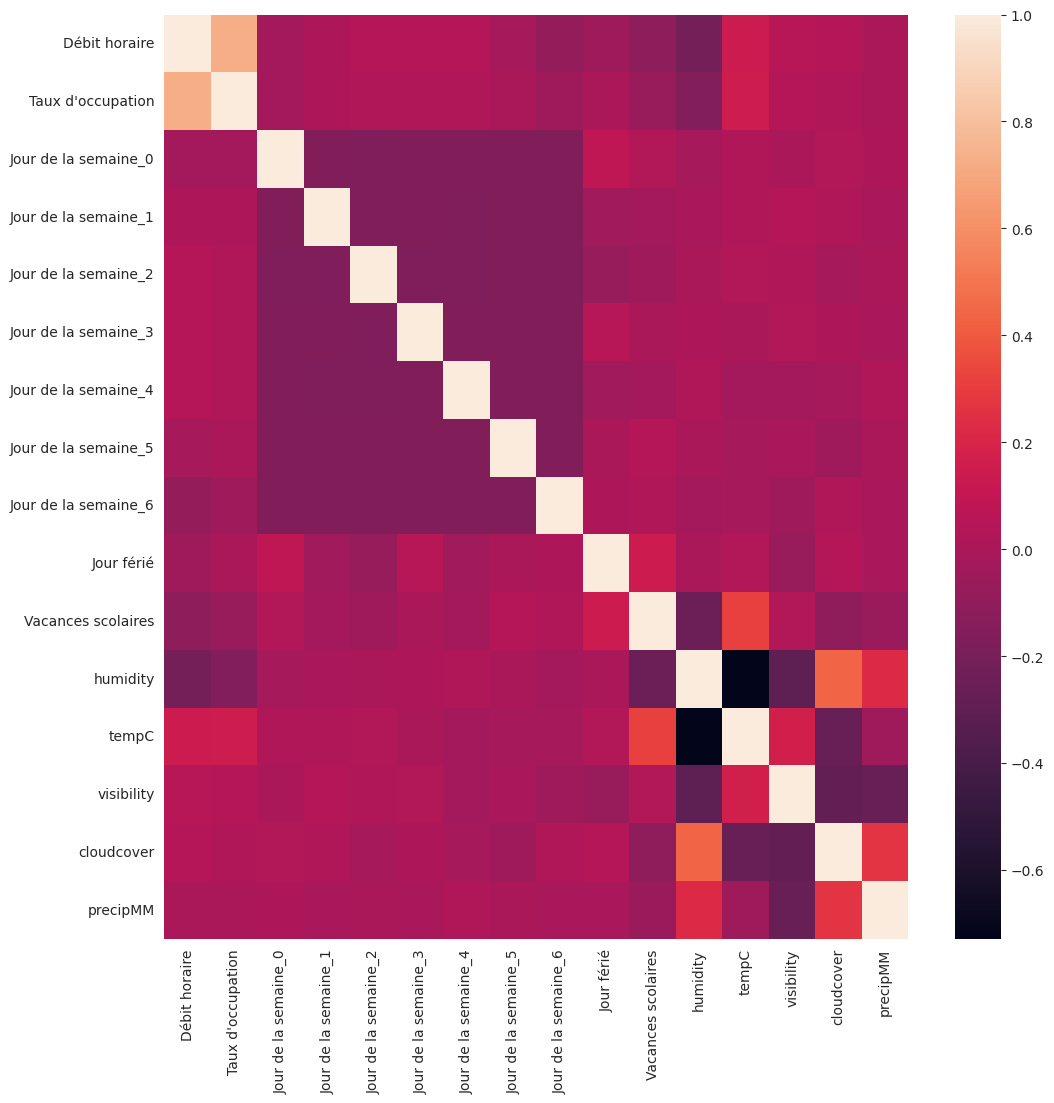

In [30]:
corr_matrix = df_filtered.corr()
with sns.axes_style("white"):
    plt.figure(figsize=(12,12))
    ax = sns.heatmap(corr_matrix)


In [31]:
df_ce = df_filtered[df_filtered['filename']=='champs-elysees.csv']
df_sts = df_filtered[df_filtered['filename']=='saints-peres.csv']
df_conv = df_filtered[df_filtered['filename']=='convention.csv']

In [32]:
df_ce = fill_missing_values(df_ce)
df_sts = fill_missing_values(df_sts)
df_conv = fill_missing_values(df_conv)

In [33]:
df_ce = set_indexes_for_timeseries(df_ce)
df_sts = set_indexes_for_timeseries(df_sts)
df_conv = set_indexes_for_timeseries(df_conv)


In [34]:
df_train_ce, df_test_ce = get_train_test(df_ce)
df_train_sts, df_test_sts = get_train_test(df_sts)
df_train_conv, df_test_conv = get_train_test(df_conv)

## Moyenne mobile du débit horaire sur fenêtre de 24h

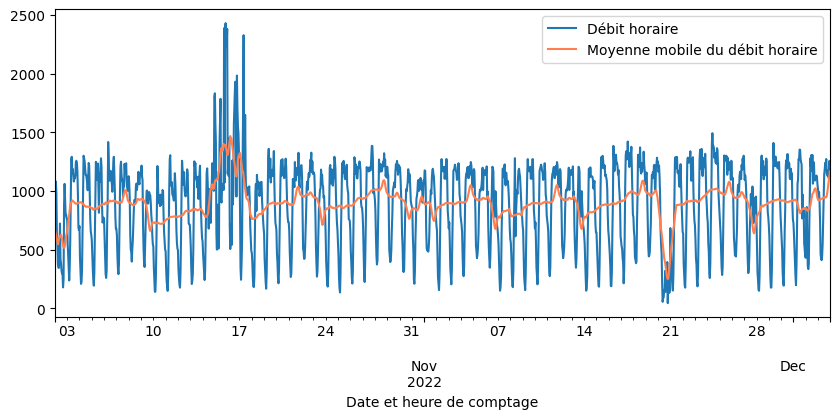

In [35]:
from datetime import datetime
mobile_mean = df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]["Débit horaire"].dropna().rolling(24, center=True, min_periods=1).mean()
df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]["Débit horaire"].dropna().plot(figsize=(10,4), label = 'Débit horaire')
mobile_mean.plot(figsize=(10,4), color='coral', label = 'Moyenne mobile du débit horaire')
plt.legend()
plt.show()

## Moyenne mobile du taux d'occupation sur fenêtre de 24h

## Grid search sur les paramètres de SARIMA

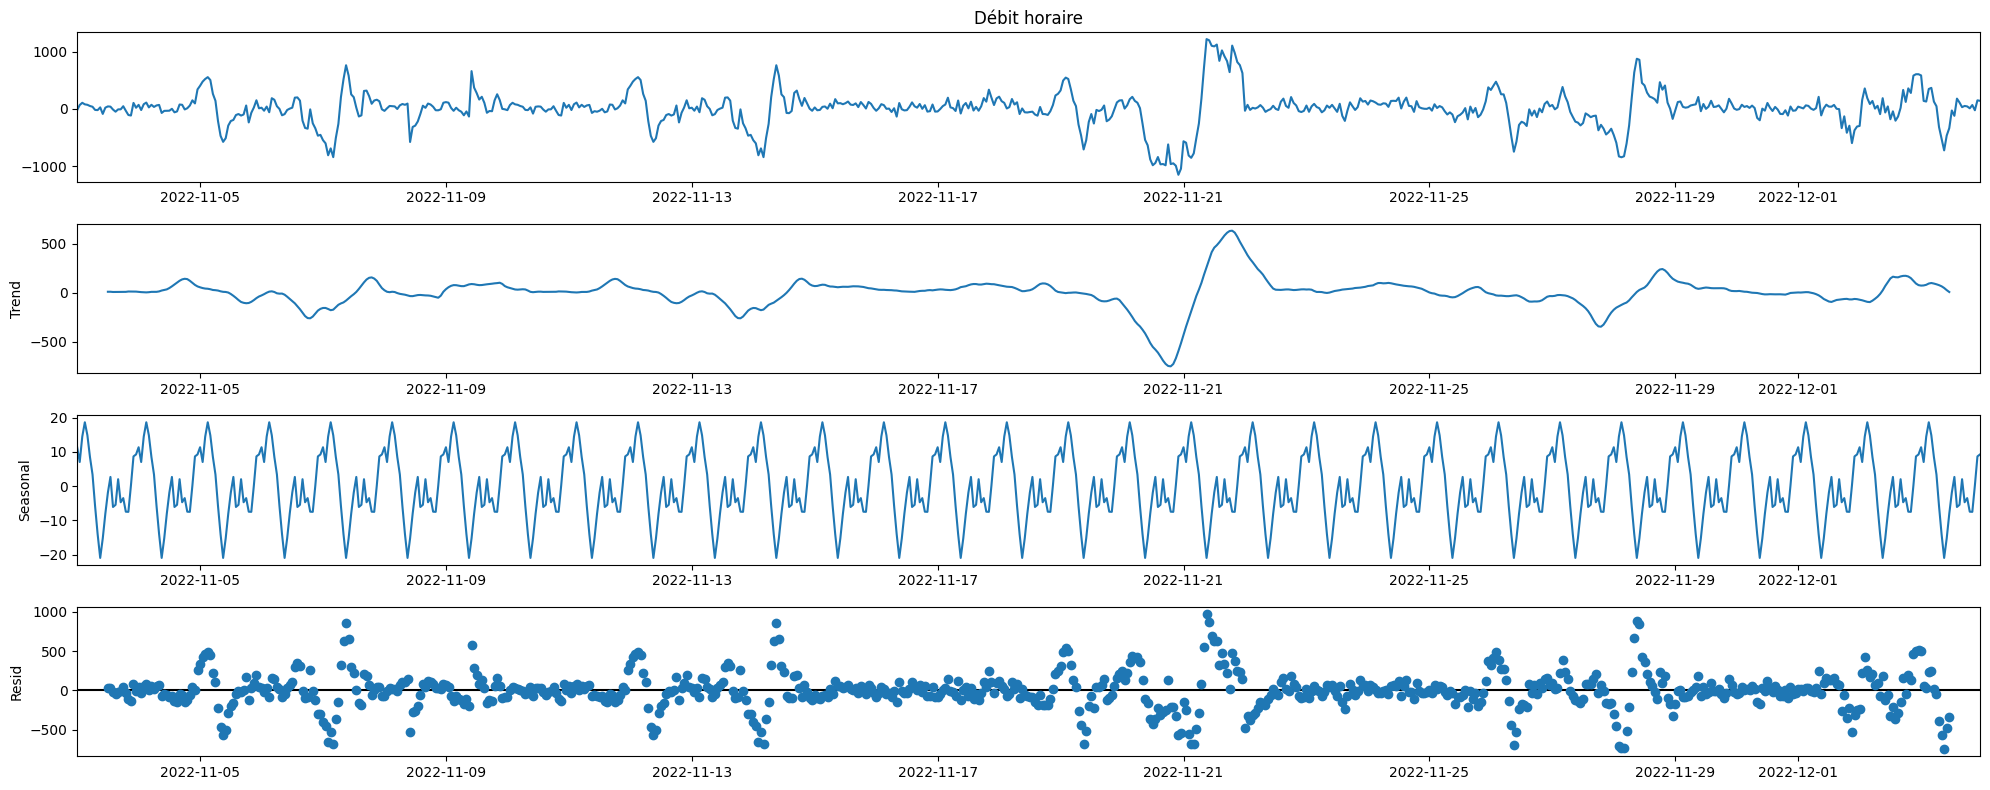

In [32]:

plt.rcParams["figure.figsize"] = (20,8)
decomposition = sm.tsa.seasonal_decompose(df_train_ce[df_train_ce["Date"]>datetime(2022,11,1).date()]["Débit horaire"].diff(24).dropna(), model='additive')
fig = decomposition.plot()
plt.show()


/home/romainfournier/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


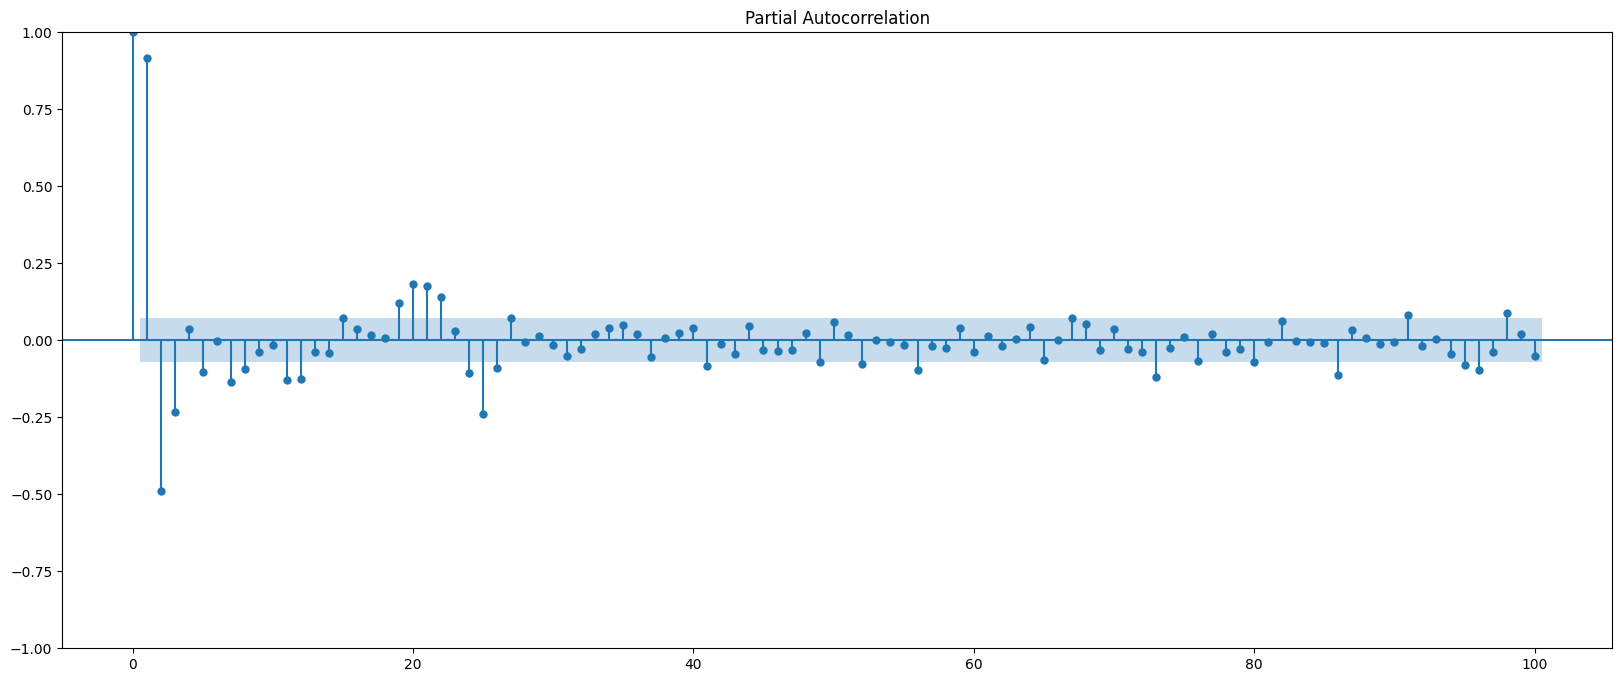

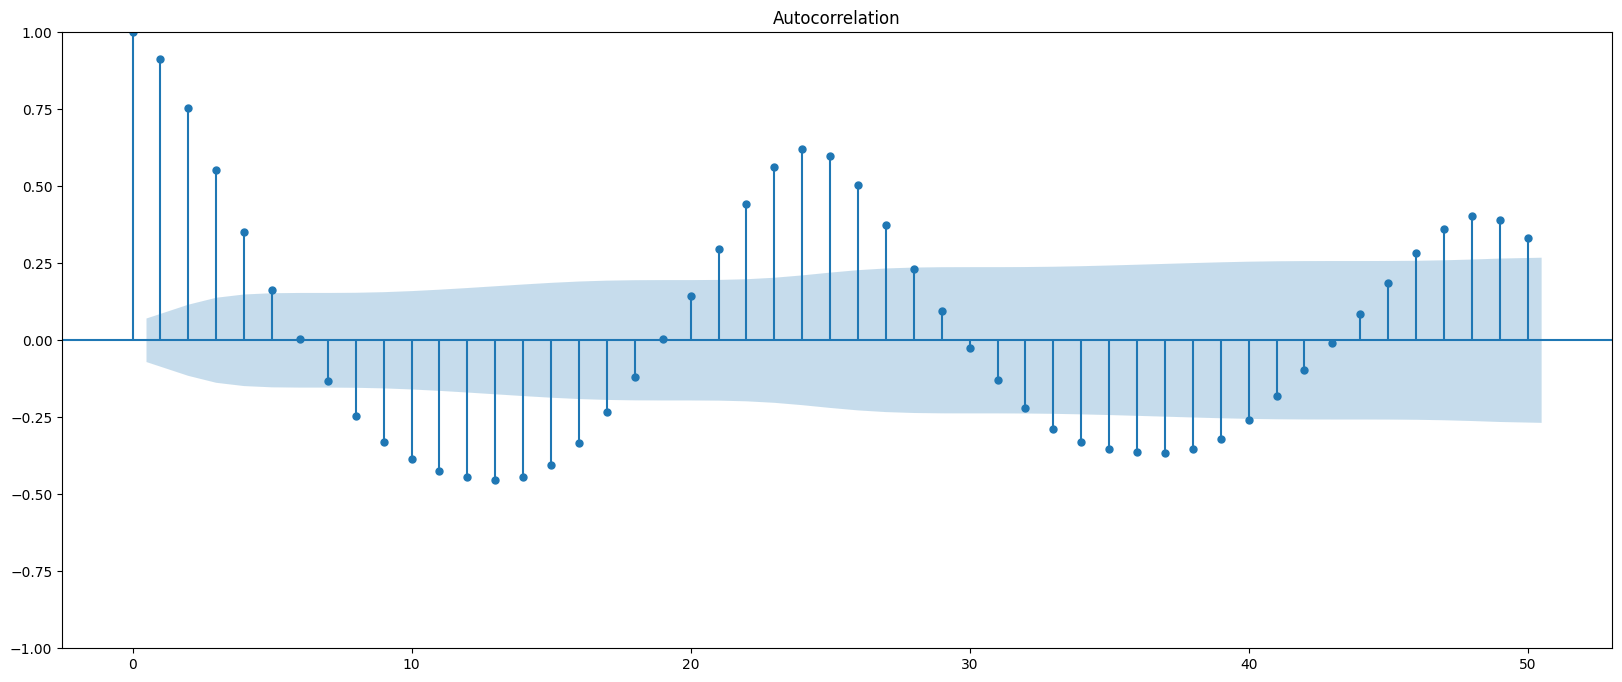

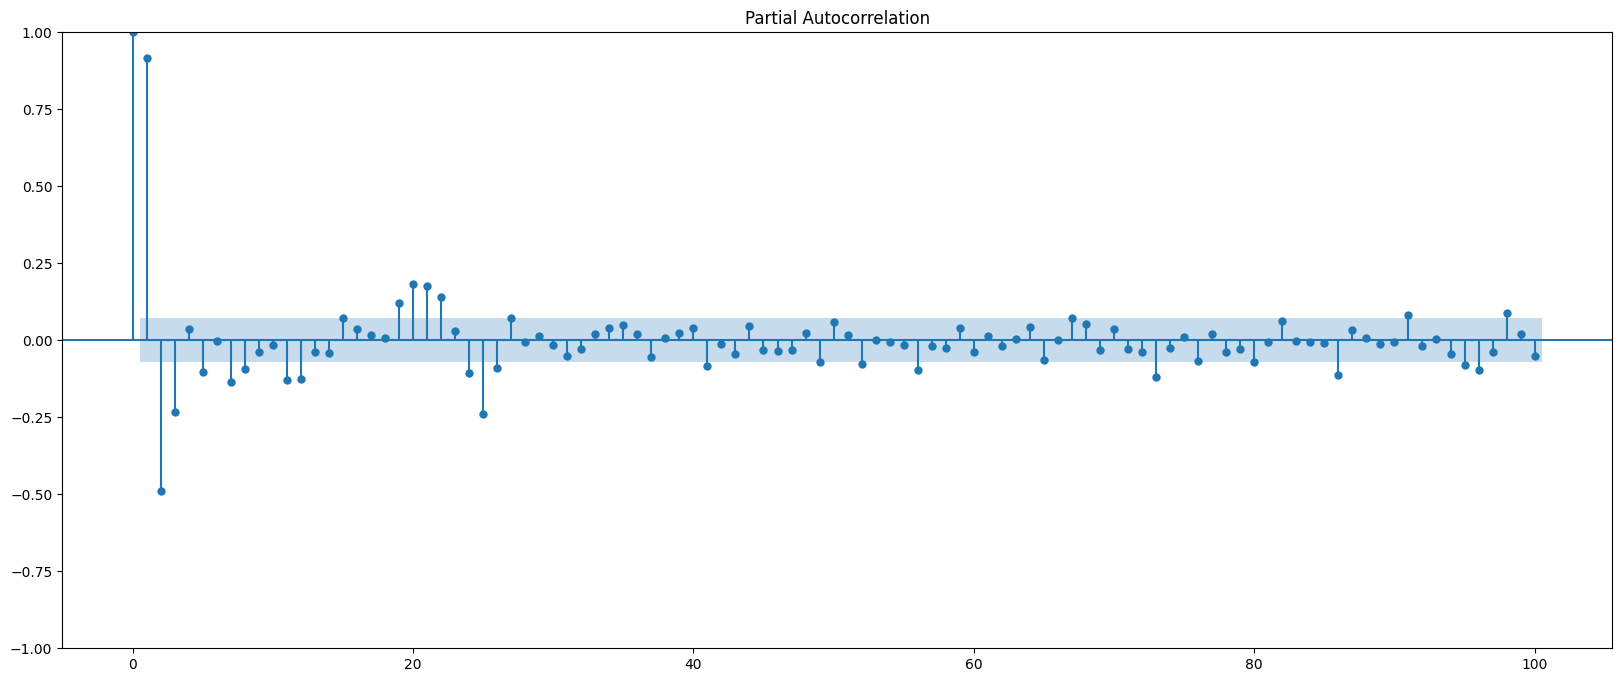

In [33]:
from datetime import datetime
plot_acf(df_train_ce[df_train_ce["Date"]>datetime(2022,11,1).date()]["Débit horaire"].dropna(),lags=50)
plot_pacf(df_train_ce[df_train_ce["Date"]>datetime(2022,11,1).date()]["Débit horaire"].dropna(),lags=100)

/home/romainfournier/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


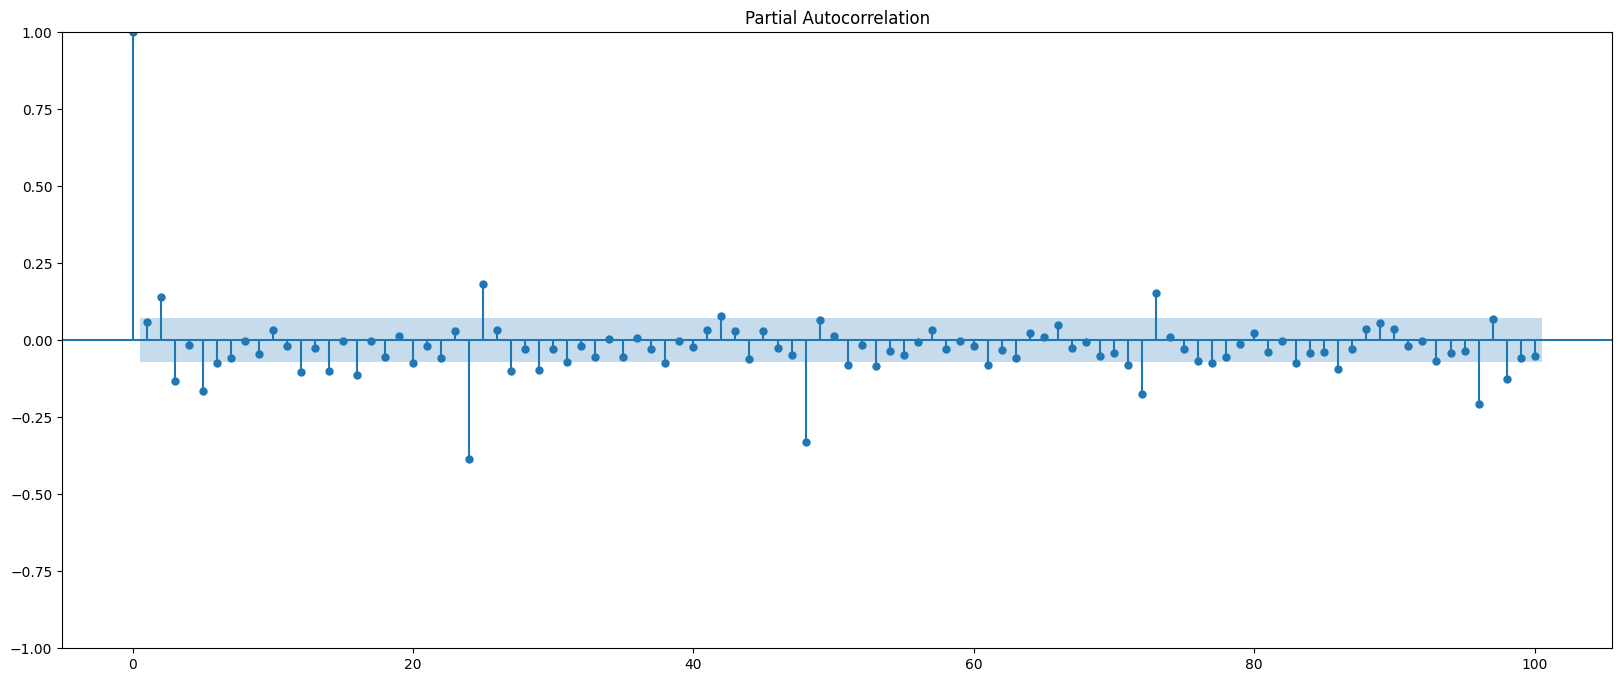

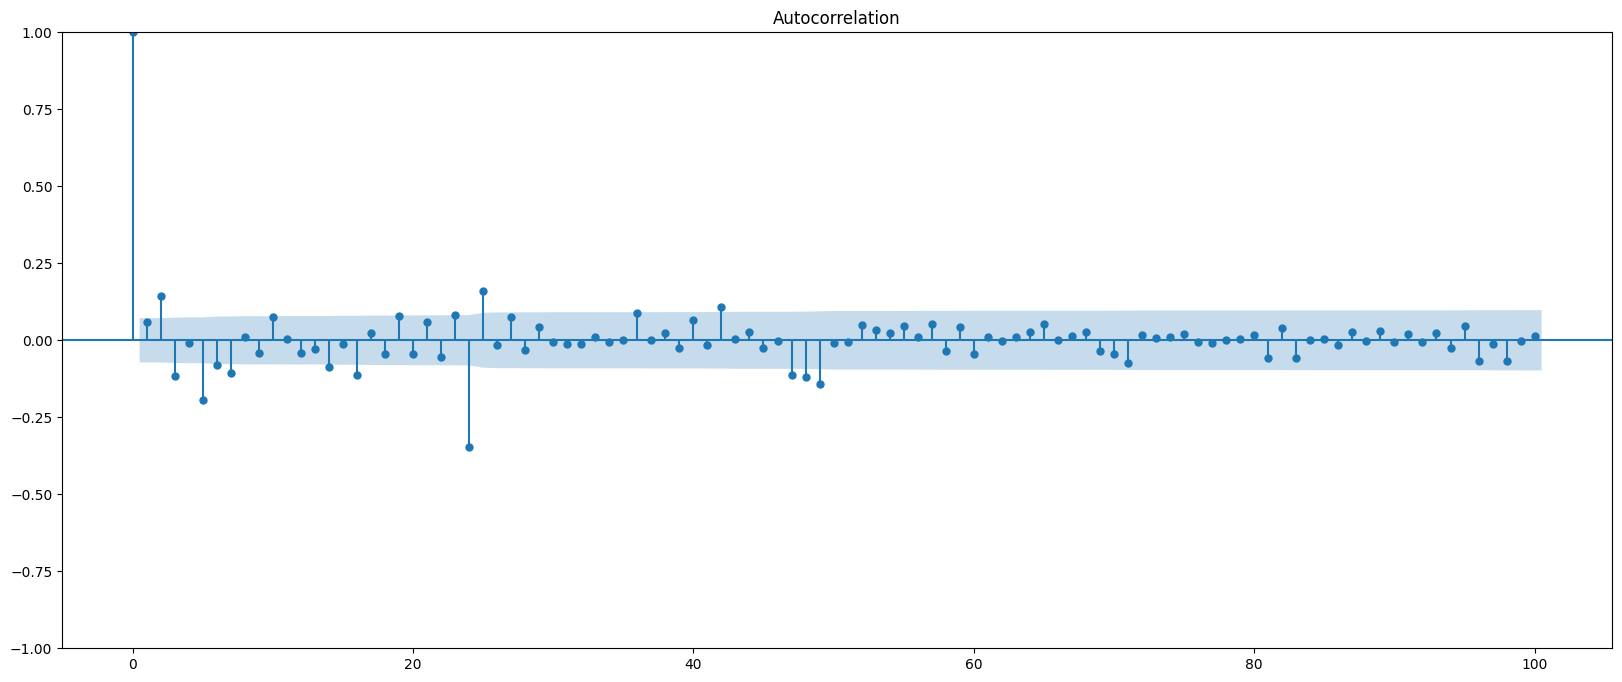

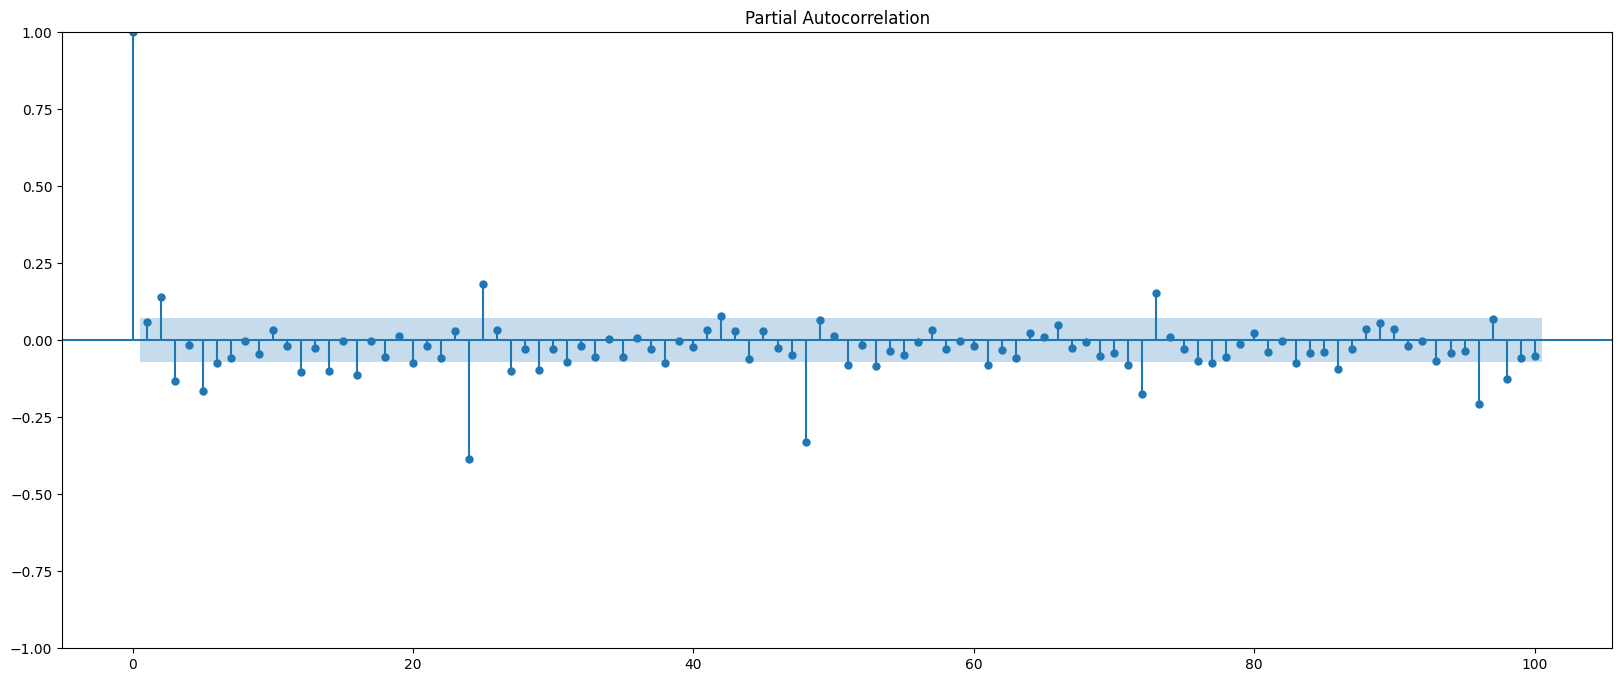

In [39]:
plot_acf(df_train_ce[df_train_ce["Date"]>datetime(2022,11,1).date()]["Débit horaire"].diff(24).diff().dropna(),lags=100)
plot_pacf(df_train_ce[df_train_ce["Date"]>datetime(2022,11,1).date()]["Débit horaire"].diff(24).diff().dropna(),lags=100)

- on choisit d = 1
- on choisit p = 1 
- on choisit q  = 2
- on choisit m = 24 
- on choisit P = 0
- on choisit Q = 2
- on choisit D= 1

In [63]:
exog_train=df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]\
[['Jour férié','Vacances scolaires','Jour de la semaine_0','Jour de la semaine_1','Jour de la semaine_2','Jour de la semaine_3',
'Jour de la semaine_4','Jour de la semaine_5','Jour de la semaine_6','Durée avant les prochaines vacances scolaires','tempC','visibility','totalSnow_cm','precipMM']]

exog_train['Durée avant les prochaines vacances scolaires'] = exog_train['Durée avant les prochaines vacances scolaires'].dt.days
exog_train = exog_train.astype(float)


In [64]:
import time
import numpy as np
from sklearn.metrics import mean_squared_error

p=0
d=1
q=0
m=24
P=2
D=1
Q= 1
fitting = True
if fitting:
    s = time.time()
    mod = sm.tsa.statespace.SARIMAX(df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]["Débit horaire"].dropna(),order=(p,q,d),seasonal_order=(P,D,Q,m),enforce_stationarity=False,enforce_invertibility=False,exog=exog_train)
    model = mod.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.54616D+00    |proj g|=  3.55055D-01


 This problem is unconstrained.



At iterate    5    f=  6.49834D+00    |proj g|=  4.10478D-01

At iterate   10    f=  6.46759D+00    |proj g|=  5.56169D-03

At iterate   15    f=  6.46744D+00    |proj g|=  5.73537D-03

At iterate   20    f=  6.46084D+00    |proj g|=  3.85063D-02

At iterate   25    f=  6.45715D+00    |proj g|=  3.47382D-03

At iterate   30    f=  6.44913D+00    |proj g|=  4.59679D-02

At iterate   35    f=  6.35638D+00    |proj g|=  5.23826D-02

At iterate   40    f=  6.35276D+00    |proj g|=  4.58379D-04

At iterate   45    f=  6.35274D+00    |proj g|=  3.64837D-03


/home/romainfournier/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.35210D+00    |proj g|=  1.72509D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     60      1     0     0   1.725D-02   6.352D+00
  F =   6.3521021250161471     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [65]:

a = df_test_ce.index.min()
b = df_test_ce.index.max()
a,b

(Timestamp('2022-12-04 00:00:00', freq='H'),
 Timestamp('2022-12-09 00:00:00', freq='H'))

In [66]:
exog_test=df_test_ce\
[['Jour férié','Vacances scolaires','Jour de la semaine_0','Jour de la semaine_1','Jour de la semaine_2','Jour de la semaine_3',
'Jour de la semaine_4','Jour de la semaine_5','Jour de la semaine_6','Durée avant les prochaines vacances scolaires','tempC','visibility','totalSnow_cm','precipMM']]

exog_test['Durée avant les prochaines vacances scolaires'] = exog_test['Durée avant les prochaines vacances scolaires'].dt.days
exog_test = exog_test.astype(float)

/tmp/ipykernel_566/1276844268.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog_test['Durée avant les prochaines vacances scolaires'] = exog_test['Durée avant les prochaines vacances scolaires'].dt.days


In [70]:
df_train_ce.index.min()

Timestamp('2021-11-01 04:00:00', freq='H')

In [67]:
pred = model.predict(start=a,end=b,exog=exog_test)
pred_train = model.predict(start=df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()].index.min(),
                           end=df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()].index.max(),
                           exog = exog_train)
e = time.time()
print(f"Temps d'éxecution: {e-s}")
rmse = round(np.sqrt(mean_squared_error(df_test_ce["Débit horaire"], pred)),1)
print(rmse)
plt.plot(df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]["Débit horaire"], label='Données')
plt.plot(df_test_ce["Débit horaire"], "--",  label='Target')
plt.plot(pred, label='Prediction')
plt.plot(pred_train, label = 'Prediction train')
plt.xticks(rotation=45)
plt.title(f'Predictions pour Champs Élysées du 22 au 27 Novembre 2020 \n RMSE={rmse}')
plt.legend()
plt.show()


MissingDataError: exog contains inf or nans

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
p=3
fitting = True
if fitting:
    s = time.time()
    mod = AutoReg(df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]["Débit horaire"],lags=3,trend="ct",exog=exog_train)
    model = mod.fit()

In [ ]:
pred = model.predict(start=a,end=b,exog_oos=exog_test)
pred_train = model.predict(start=df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()].index.min(),
                           end=df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()].index.max(),exog=exog_train)
e = time.time()
print(f"Temps d'éxecution: {e-s}")
rmse = round(np.sqrt(mean_squared_error(df_test_ce["Débit horaire"], pred)),1)
print(rmse)
plt.plot(df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]["Débit horaire"], label='Données')
plt.plot(df_test_ce["Débit horaire"], "--",  label='Target')
plt.plot(pred, label='Prediction')
plt.plot(pred_train, label = 'Prediction train')
plt.xticks(rotation=45)
plt.title(f'Predictions pour Champs Élysées du 22 au 27 Novembre 2020 \n RMSE={rmse}')
plt.legend()
plt.show()


In [ ]:
from pmdarima.arima import auto_arima
model = auto_arima(df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]["Débit horaire"],
                  start_p=2,
                  max_p=2,
                  seasonal=True,
                  start_P=2,
                start_q=0,
                   max_q=0,
                  max_P=2,
                  start_Q=1,
                  max_Q=3,
                   m=24,
                  stepwise=True)

In [91]:
from pmdarima.arima import ndiffs, nsdiffs,auto_arima
adf_diffs = ndiffs(df_train_ce[df_train_ce["Date"]>datetime(2022,11,1).date()]["Débit horaire"], alpha=0.05, test='adf', max_d=10)
kpss_diffs = ndiffs(df_train_ce[df_train_ce["Date"]>datetime(2022,11,1).date()]["Débit horaire"], alpha=0.05, test='kpss', max_d=10)

ValueError: Input contains NaN.

In [53]:
kpss_diffs, adf_diffs

(0, 0)

In [55]:
D = nsdiffs(df_train_ce[df_train_ce["Date"]>datetime(2022,11,1).date()]["Débit horaire"].dropna(), m=24, max_D=5, test='ocsb')
D

0

In [ ]:
results = auto_arima(df_train_ce[df_train_ce["Date"]>datetime(2022,11,1).date()]["Débit horaire"],
                  p=2,
                     d=0,
                q=0,
                     seasonal=True,
                P=2,
                  start_Q=1,
                     D=0,
                  max_Q=5,
                   m=24,
                  stepwise=True)

results.summary()

In [ ]:
import time
import numpy as np
from sklearn.metrics import mean_squared_error

p=3
d=0
q=5
m=24
P=2
D=1
Q= 2
fitting = True
if fitting:
    s = time.time()
    mod = sm.tsa.statespace.SARIMAX(df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]["Débit horaire"],order=(p,q,d),seasonal_order=(P,D,Q,m),enforce_stationarity=False,enforce_invertibility=False,exog=exog_train)
    model = mod.fit()
    



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.24054D+00    |proj g|=  1.17823D-01

At iterate    5    f=  7.21630D+00    |proj g|=  2.05725D-02

At iterate   10    f=  7.21584D+00    |proj g|=  1.34696D-03

At iterate   15    f=  7.21577D+00    |proj g|=  4.04424D-03

At iterate   20    f=  7.21521D+00    |proj g|=  1.88534D-02

At iterate   25    f=  7.21510D+00    |proj g|=  1.77223D-03

At iterate   30    f=  7.21495D+00    |proj g|=  7.12929D-03

At iterate   35    f=  7.19127D+00    |proj g|=  2.11046D-01

At iterate   40    f=  7.12180D+00    |proj g|=  8.22406D-02

At iterate   45    f=  7.11968D+00    |proj g|=  4.79133D-03


/home/romainfournier/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  7.11964D+00    |proj g|=  1.51849D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     57      1     0     0   1.518D-03   7.120D+00
  F =   7.1196388866876719     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [2]:
#df_test_ce = set_indexes_for_timeseries(df_test_ce)
a = df_test_ce.index.min()
b = df_test_ce.index.max()
a,b

NameError: name 'df_test_ce' is not defined

In [3]:
pred = model.predict(start=a,end=b,exog=exog_test)
pred_train = model.predict(start=df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()].index.min(),
                           end=df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()].index.max(),exog=exog_train)

rmse = round(np.sqrt(mean_squared_error(df_test_ce["Débit horaire"], pred)),1)
print(rmse)
plt.plot(df_train_ce[df_train_ce["Date"]>datetime(2022,10,1).date()]["Débit horaire"], label='Données')
plt.plot(df_test_ce["Débit horaire"], "--",  label='Target')
plt.plot(pred, label='Prediction')
plt.plot(pred_train, label = 'Prediction train')
plt.xticks(rotation=45)
plt.title(f'Predictions pour Champs Élysées du 27 novembre au 2 Décembre 2022 \n RMSE={rmse}')
plt.legend()
plt.show()


NameError: name 'model' is not defined

best_score : 236.1, (2,0,0)*(2,1,2)